**import libraries**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from collections import Counter

# for clustering the images 
from sklearn.cluster import KMeans

**load images**

In [ ]:
# take multiple images for which co-saliency is to be found

img1 = cv2.imread('/content/waterfall3.jpeg')     
img2 = cv2.imread('/content/waterfall4.jpg')

_Convert to RGB_

In [ ]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [ ]:
image_list = [img1,img2]

_Plot images_

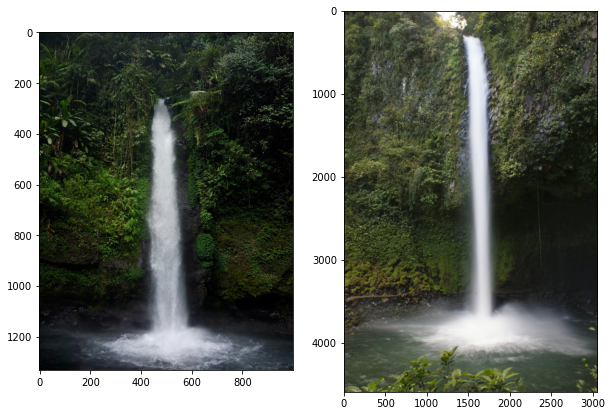

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(image_list)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(image_list[i])

In [ ]:
print(img1.shape)
print(img2.shape)

(1333, 1000, 3)
(4592, 3056, 3)


######**Intra Image Clusters**

_Reshaping the images to 2D for clustering_

In [ ]:
img_2D = []

for i in range(len(image_list)):
  im = image_list[i]
  im_2d = im.reshape((-1,3))        # flattening the image
  im_2d = np.float32(im_2d)

  img_2D.append(im_2d)

_K-Means Clustering_

In [ ]:
intra_clusters = []

for i in range(len(image_list)):
  clus = KMeans(n_clusters=3, random_state=0).fit(img_2D[i])
  intra_clusters.append(clus)

In [ ]:
clustered_imgs = []

for i in range(len(intra_clusters)):
  center_i = intra_clusters[i].cluster_centers_
  label_i = intra_clusters[i].labels_

  center_i = np.uint8(center_i)

  # convert all pixels to the color of the centroids
  clustered_img_i = center_i[label_i.flatten()]
  clustered_img_i = clustered_img_i.reshape(image_list[i].shape)
  clustered_imgs.append(clustered_img_i)

_Plot the segmented image(pixels replaced with colors of their clusters)_

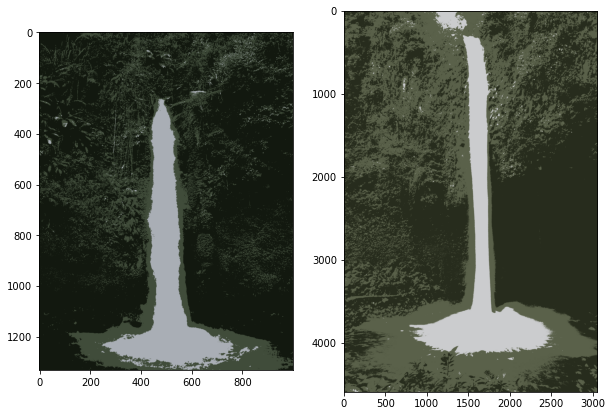

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(clustered_imgs)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(clustered_imgs[i])

######**Inter image clusters**

_Combine the images for clustering_

In [ ]:
data_matrix = np.concatenate(img_2D,axis=0)
print(data_matrix.shape)

(15366152, 3)


_Apply k-means_

In [ ]:
clustered_data = KMeans(n_clusters=3, random_state=0).fit(data_matrix)

In [ ]:
centroids = clustered_data.cluster_centers_
centeroids = np.uint8(centroids)

print(centroids)

[[ 35.6205    40.29606   27.152668]
 [ 87.70351   94.70189   71.88588 ]
 [199.47081  200.75867  202.74092 ]]


In [ ]:
label = clustered_data.labels_
print(label.shape)

(15366152,)


In [ ]:
label1 = label[:img_2D[0].shape[0]]
label2 = label[img_2D[0].shape[0]:]

clusters = centroids.shape[0]
label_list = [label1,label2]

_Plot inter-image clusters_

In [ ]:
l = []

for i in range(len(image_list)):
  l1 = []
  for k in range(clusters):

    cluster = np.copy(image_list[i])
    cluster = cluster.reshape((-1,3))

    #disable all other clusters except kth cluster
    cluster[label_list[i]!=k] = [0,0,0]
    cluster = cluster.reshape(image_list[i].shape)
    l1.append(cluster)
  
  l.append(l1)


THE BLACK PORTION IN EACH IMAGE IS THE MENTIONED CLUSTER.

The colour represented by the specified cluster appears in black in the image.



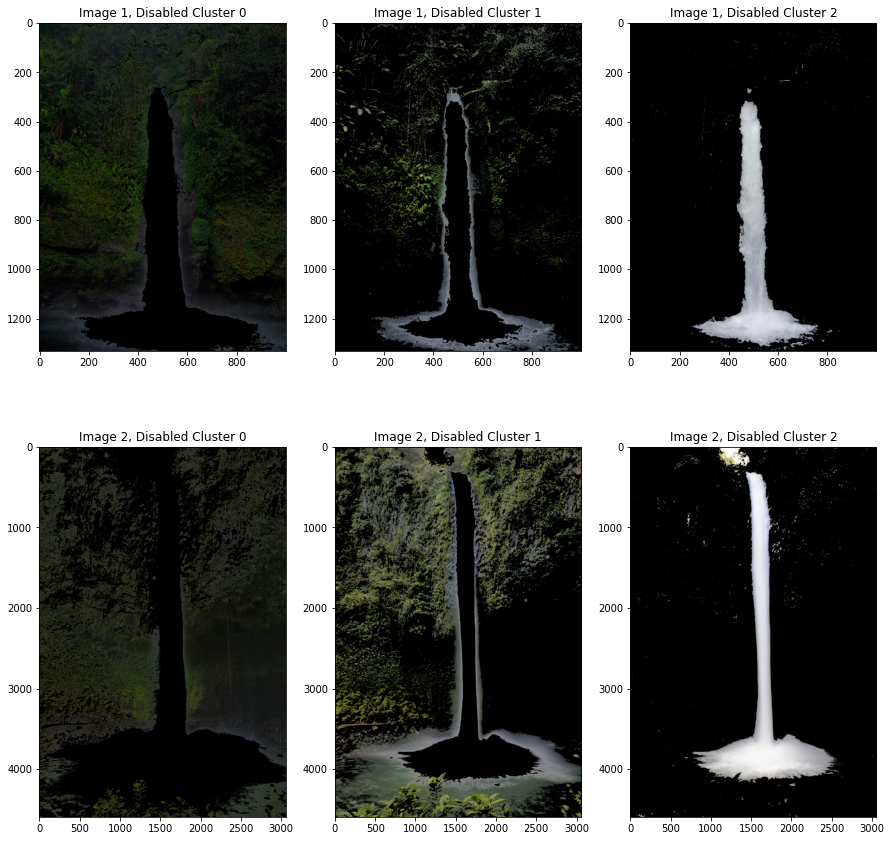

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (15,15))

print("\nTHE BLACK PORTION IN EACH IMAGE IS THE MENTIONED CLUSTER.")
print("\nThe colour represented by the specified cluster appears in black in the image.\n")
w = 0
for i in range(len(image_list)):
  li = l[i]

  for j in range(len(li)):
    w+=1
    plt.subplot(2,3,w)
    plt.title("Image %d, Disabled Cluster %d"%(i+1,j))
    plt.imshow(li[j])



######**Contrast Cue**

In [ ]:
contrast_cue = defaultdict()
N = label.shape[0]

for k in range(0,clusters):
  sum = 0
  for i in range(0,clusters):
    if(i!=k):
      n = Counter(label)[i]
      l = np.linalg.norm(centroids[k]- centroids[i])
      sum += n*l/N
  
  contrast_cue[k] = sum

In [ ]:
contrast_cue

defaultdict(None,
            {0: 63.29842733487243,
             1: 65.54639375692246,
             2: 225.88837984563278})

_Plotting the result of Contrast Cue_

In [ ]:
Contrast_output = []

for m in range(len(image_list)):
  img = image_list[m]
  clust_label = label_list[m]
  cCue_img = np.zeros((img.shape[0]*img.shape[1]))

  for x in range(img.shape[0]*img.shape[1]):
    c_cue = contrast_cue[clust_label[x]]
    cCue_img[x] = c_cue
  
  cCue_img = cCue_img.reshape(img.shape[0],img.shape[1])

  Contrast_output.append(cCue_img)

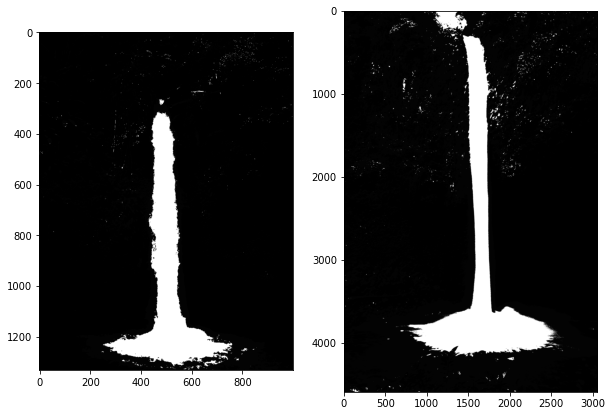

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(Contrast_output)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(Contrast_output[i],cmap='gray')

######**Spatial Cue**

> _for each image_
> (x,y) --> (RGB,cluster)





In [ ]:
img_dict = defaultdict(defaultdict)

for m in range(0,2):
  temp_dict = defaultdict()
  img = image_list[m]
  clust_label = label_list[m]

  for i in range(1,img.shape[0]):
    for j in range(1,img.shape[1]):
      temp_dict[(i,j)] = (img[i][j],clust_label[i*j])
  
  img_dict[m] = temp_dict

_Calculating Spatial Cue_

In [ ]:
def normpdf(x, var):
  denom = (2*math.pi*var)**.5
  num = math.exp(-(float(x))**2/(2*var))
  
  return num/denom


In [ ]:
spatial_cue = defaultdict()

for k in range(0,clusters):
  nk = Counter(label)[k]        # number of pixels in the kth cluster
  sum_clus = 0                  # value of spatial cue of kth cluster

  for m in range(len(image_list)):
    pixel_dict = img_dict[m]
    img = image_list[m]
  
    var = (((img.shape[0])**2 + (img.shape[1])**2) **0.5 )/2

    # normalised image center
    img_centre = np.array([(img.shape[0]/2)/img.shape[0],(img.shape[1]/2)/img.shape[1]])
    
    sum_img = 0               # sum stored at image level
    for key,val in pixel_dict.items():
      #cluster number of the pixel
      clu_id = val[1]

      # normalised pixel position
      z = np.array([key[0]/img.shape[0],key[1]/img.shape[1]])  
      
      # euclidean distance between z and img_centre
      x = np.linalg.norm(z-img_centre)

      # Gaussian pdf
      N = normpdf(x,var)

      delta = 0
      if(clu_id==k):
        delta = 1
      else:
        delta = 0
      
      sum_img+= N*delta

    sum_clus+= sum_img
  
  spatial_cue[k] = sum_clus/nk

_Plotting the Spatial Cue obtained_

In [ ]:
Spatial_output = []

for m in range(len(image_list)):
  img = image_list[m]
  clust_label = label_list[m]
  sCue_img = np.zeros((img.shape[0]*img.shape[1]))

  for x in range(img.shape[0]*img.shape[1]):
    s_cue = spatial_cue[clust_label[x]]
    sCue_img[x] = s_cue
  
  sCue_img = sCue_img.reshape(img.shape[0],img.shape[1])

  Spatial_output.append(sCue_img)

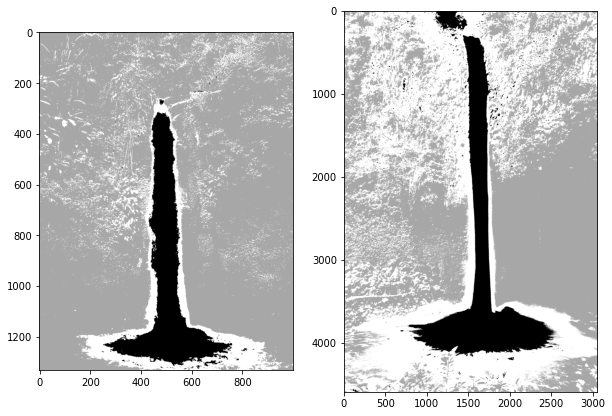

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(Spatial_output)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(Spatial_output[i],cmap='gray')

######**Corresponding Cue**

In [ ]:
corresponding_cue = defaultdict(list)

for k in range(clusters):
  nk = Counter(label)[k]           # number of pixels in kth cluster

  for m in range(len(image_list)):
    clus_label = label_list[m]
    corresponding_cue[k].append((Counter(clus_label)[k]/nk))

In [ ]:
for k in range(clusters):
  a = corresponding_cue[k]
  corresponding_cue[k] = 1/(np.var(a) + 1)

In [ ]:
corresponding_cue

defaultdict(list,
            {0: 0.8802048159454823,
             1: 0.8192158665490846,
             2: 0.8486308475198626})

_Plotting Corresponding cue obtained_

In [ ]:
Corresponding_output = []

for m in range(len(image_list)):
  img = image_list[m]
  clust_label = label_list[m]
  coCue_img = np.zeros((img.shape[0]*img.shape[1]))

  for x in range(img.shape[0]*img.shape[1]):
    co_cue = corresponding_cue[clust_label[x]]
    coCue_img[x] = co_cue
  
  coCue_img = coCue_img.reshape(img.shape[0],img.shape[1])

  Corresponding_output.append(coCue_img)

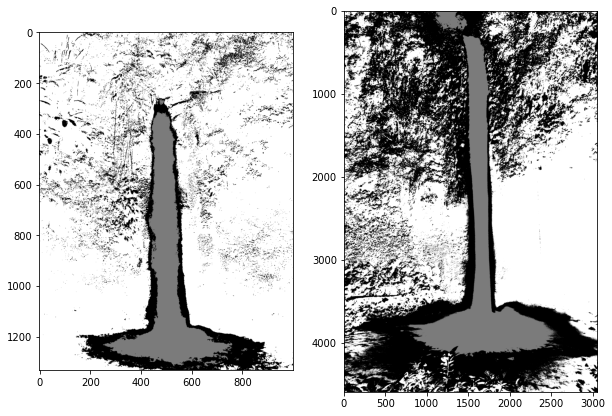

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(Corresponding_output)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(Corresponding_output[i],cmap='gray')

######**Co-saliency Map**

In [ ]:
co_saliency = defaultdict()

for k in range(clusters):
  co_saliency[k] = contrast_cue[k] * spatial_cue[k] * corresponding_cue[k]

In [ ]:
Cosaliency_output = []

for m in range(len(image_list)):
  img = image_list[m]
  clust_label = label_list[m]
  sal_img = np.zeros((img.shape[0]*img.shape[1]))

  for x in range(img.shape[0]*img.shape[1]):
    sal_img[x] = co_saliency[clust_label[x]]
  
  sal_img = sal_img.reshape(img.shape[0],img.shape[1])

  Cosaliency_output.append(sal_img)

**Smoothening the saliency values**

In [ ]:
smoothing_dict = defaultdict(defaultdict)
smoothed_value = defaultdict()

for m in range(len(image_list)):
  pixel_dict = img_dict[m]
  img = image_list[m]

  for key,val in pixel_dict.items():
    sum = 0
    for k in range(clusters):
      var = corresponding_cue[k]
      v = val[0]
      x = np.linalg.norm(v- centroids[k])

      # Gaussian pdf
      N = normpdf(x,var)
      # P(Ck)
      p_k = co_saliency[k]

      sum += N * p_k
    smoothed_value[key] = sum

  smoothing_dict[m] = smoothed_value

In [ ]:
Cosaliency_output = []

for m in range(len(image_list)):
  img = image_list[m]
  new_img = np.zeros([img.shape[0],img.shape[1]])
  smoothing_val = smoothing_dict[m]

  for x in range(1,img.shape[0]):
    for y in range(1,img.shape[1]):
      new_img[x][y] = smoothing_val[(x,y)]
  
  Cosaliency_output.append(new_img)

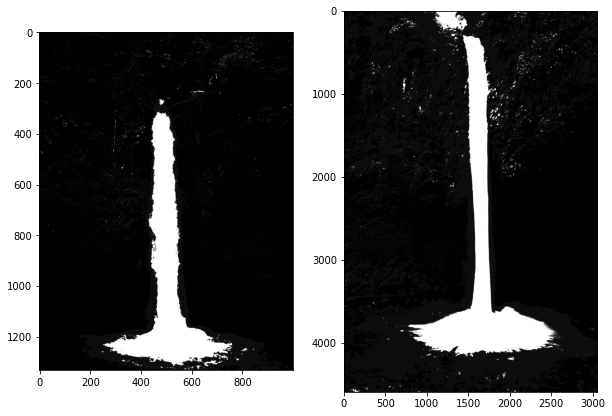

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

k=0
for i in range(len(Cosaliency_output)):
  k+=1
  plt.subplot(1,2,k)
  plt.imshow(Cosaliency_output[i],cmap='gray')